In [1]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from google.colab import drive
#!pip install transformers datasets accelerate


drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


dataset = load_dataset("isaacrehg/poetry-instructions", verification_mode="no_checks")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

(…)-00000-of-00001-f9026b3e4b9aab48.parquet:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

(…)-00000-of-00001-8b9ddb74a3fd048e.parquet:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

(…)-00000-of-00001-1c0e7b1de7a62c6e.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1322 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/111 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/331 [00:00<?, ? examples/s]

In [4]:
print(dataset)
print(dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 1764
    })
    validation: Dataset({
        features: ['conversation'],
        num_rows: 111
    })
    test: Dataset({
        features: ['conversation'],
        num_rows: 331
    })
})
{'conversation': "User: Can you write me a poem about faults and love?\nAssistant: Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [5]:
# Define parsing function
def parse_example(example):
    convo = example["conversation"]

    # Split on 'Assistant:'
    if "Assistant:" in convo:
        user_part, assistant_part = convo.split("Assistant:", 1)

        # Clean User: part
        prompt = user_part.replace("User:", "").strip()

        # Clean Assistant: part
        completion = assistant_part.strip()

    else:
        # If no Assistant:, fallback
        prompt = convo
        completion = ""

    return {
        "prompt": prompt,
        "completion": completion
    }

# Apply to all splits
dataset["train"] = dataset["train"].map(parse_example)
dataset["validation"] = dataset["validation"].map(parse_example)
dataset["test"] = dataset["test"].map(parse_example)

# Remove 'conversation' column
dataset["train"] = dataset["train"].remove_columns(['conversation'])
dataset["validation"] = dataset["validation"].remove_columns(['conversation'])
dataset["test"] = dataset["test"].remove_columns(['conversation'])

# Check result
print(dataset["train"])
print(dataset["train"].column_names)
print(dataset["train"][0])



Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1764
})
['prompt', 'completion']
{'prompt': 'Can you write me a poem about faults and love?', 'completion': "Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [6]:
path = '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi'

model = AutoModelForCausalLM.from_pretrained(os.path.join(path, "funciona_gpt2"))
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path, "funciona_gpt2"))

In [7]:
# Define tokenization function
def tokenize(example):
    # List comprehension: for each example in batch
    texts = [
        p + " " + c
        for p, c in zip(example["prompt"], example["completion"])
    ]

    # Tokenize the batch of texts
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": encodings["input_ids"]  # causal LM: labels = input_ids
    }


# Apply to each split

tokenized_train = dataset["train"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_val = dataset["validation"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_test = dataset["test"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)




Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

In [8]:
# Check result
print(tokenized_train)
print(tokenized_train.column_names)
print(tokenized_train[0])

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1764
})
['input_ids', 'attention_mask', 'labels']
{'input_ids': [6090, 345, 3551, 502, 257, 21247, 546, 31025, 290, 1842, 30, 10889, 11, 994, 338, 257, 21247, 546, 31025, 290, 1842, 25, 198, 220, 1119, 1625, 284, 1560, 534, 31025, 284, 502, 11, 198, 2990, 3706, 606, 625, 530, 416, 530, 26, 198, 40, 13818, 32227, 618, 484, 547, 1760, 11, 198, 40, 2993, 606, 477, 523, 880, 878, 11, 220, 198, 5812, 11, 484, 547, 7770, 11, 1165, 7770, 284, 766, 198, 7120, 31025, 550, 925, 502, 1842, 345, 517, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

In [9]:
training_args = TrainingArguments(
    output_dir=os.path.join(path, "funciona_gpt2_f"),
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    learning_rate=1e-4,
    fp16=True,
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Validation results: {eval_results}")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

<ipython-input-9-540715bc45fe>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,3.514800
20,3.195400
30,3.446500
40,3.139000
50,3.526300
60,3.173200
70,3.197900
80,3.097300
90,3.075300
100,2.905900


Step,Training Loss
10,3.514800
20,3.195400
30,3.446500
40,3.139000
50,3.526300
60,3.173200
70,3.197900
80,3.097300
90,3.075300
100,2.905900


Validation results: {'eval_loss': 2.1563966274261475, 'eval_runtime': 2.3019, 'eval_samples_per_second': 48.22, 'eval_steps_per_second': 6.082, 'epoch': 10.0}
Test results: {'eval_loss': 2.151167392730713, 'eval_runtime': 6.6728, 'eval_samples_per_second': 49.605, 'eval_steps_per_second': 6.294, 'epoch': 10.0}


In [10]:
model.eval()
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red;
And I hear a great bird that says 'Go, go! Go!'--and then he goes away.  There are many such birds on earth and sea who would not be frightened by this strange song of ours: but we cannot determine whether they are truly wise or just in their wickedness alone (for Nature has made all things fit to sing): for she knows what makes the sea seem so blue as it is when it sings its true note without any harm intended.) But how should these wise men really know? They do not even pretend at present some knowledge whatsoever concerning them save that they have heard with secret ears from above everything which comes out through magic doors into every creature on earth, and other passages which speak only of words rather than facts about them.--Now let me tell you a little story very plainly stated before us already seen.] _O thou beautiful Sky!"_ We, having taken courage against our mother's evil will within ourselves unconsciously----let loose her hand again wh

In [11]:
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a poem about the sea and the sky? Sure, here's a poem about you:
  On the morning of May my mother died. She was in all the wrong; for one little note on her grave said it best--_A Poetical Death_. A few days later she posted this on twitter to say that "no poetry I've ever heard or read had such an effect upon me."
I have often been asked why poets who write in so inconsiderate a tone tend not even modestly at length with their
"What if they should be allowed," he replied simply as we shall see shortly enough.... The poet may well answer thus: _I am not indifferent toward any particular cause nor any particular style.--All artists are _poets._ Yet my love is not absolute either over these two and other things which compose him most effective artistic acts against us has always governed his life from childhood until almost ninety-six years ago when there came the publication by Mr Tod Browning himself (whose poems were published under title page) quite contrary statements made be

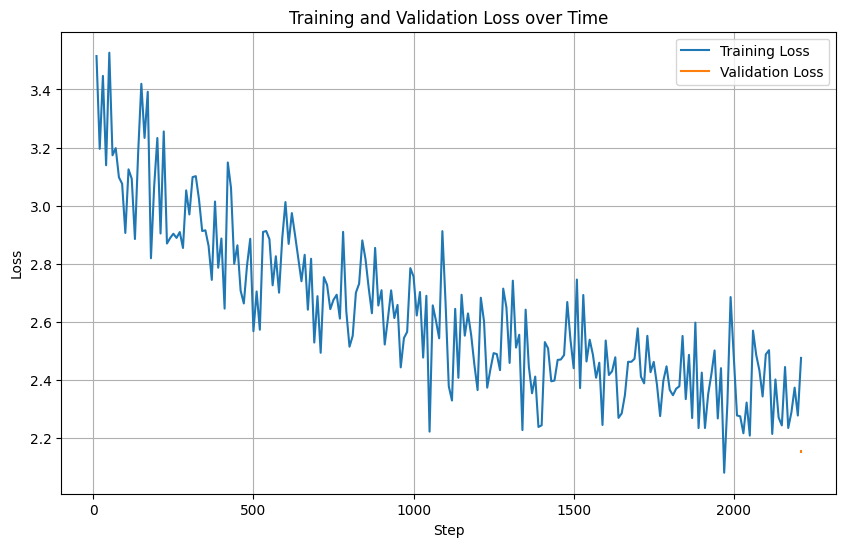

In [12]:
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Get training and eval losses
train_steps = [log["step"] for log in logs if "loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Training and Validation Loss over Time")
plt.show()
